In [1]:
# Make sure plots are inline in Jupyter
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt



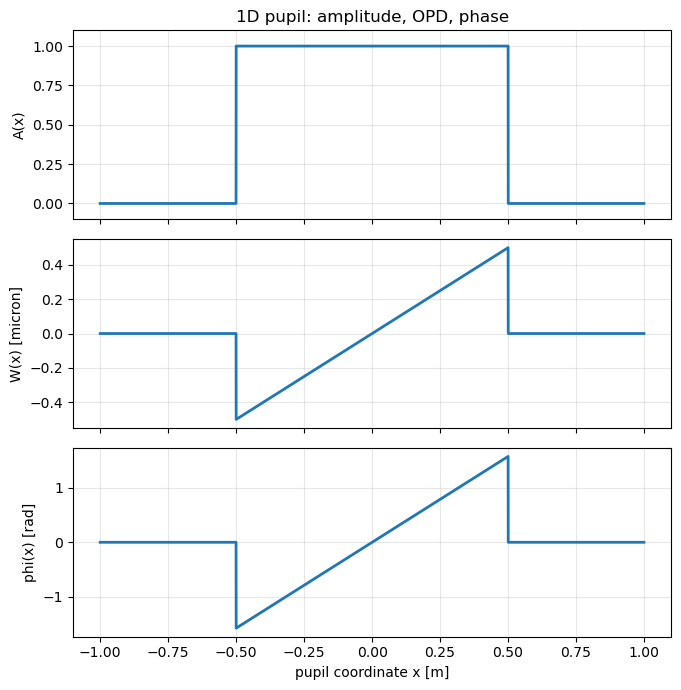

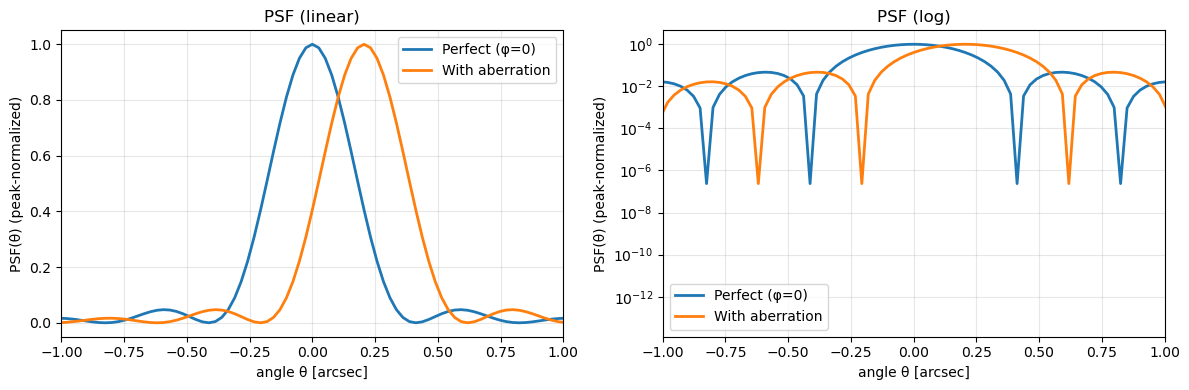

Quick sanity:
  λ = 2.00 µm, D = 1.00 m
  OPD peak-to-valley across pupil ≈ 1000.000 nm
  Phase peak-to-valley across pupil ≈ 3.142 rad


In [2]:
#HW2a

# (Use this cell as the template for HW2a Problem 1)

# Generic 1D pupil amplitude + pupil phase + FFT PSF demo


# ----------------------------
# User-controlled parameters
# ----------------------------
D = 1.0                 # telescope diameter [m]
lam = 2.0e-6            # wavelength [m]  (change to 0.5e-6 later in HW2a)

n = 4096                # pupil samples
oversample = 8          # FFT zero-padding factor (higher = smoother PSF sampling)

# Polynomial OPD model (REALISTIC):
#   W(x) = alpha*x + beta*x^2 + gamma*x^3    [meters]
# where x is in meters across the pupil.
#
# Units:
#   alpha: [m/m]   = dimensionless (a pure "wedge" OPD slope)
#   beta : [m/m^2] = 1/m
#   gamma: [m/m^3] = 1/m^2
#
# Notes:
# - alpha acts like a wavefront tilt (shifts PSF)
# - beta acts like defocus (broadens PSF symmetrically)
# - gamma gives an odd/asymmetric aberration (coma-like in 1D)

alpha = 1e-6             # OPD tilt coefficient
beta  = 0             # OPD defocus coefficient
gamma = 0             # OPD cubic coefficient


# ----------------------------
# 1) Coordinate x [m] on a window larger than the pupil
# ----------------------------
L = 2.0 * D    # total computational window size [m]
x = np.linspace(-L/2, L/2, n, endpoint=False)

# Top-hat pupil amplitude: 1 inside |x|<=D/2, 0 outside
A = (np.abs(x) <= D/2).astype(float)

# ----------------------------
# 2) OPD W(x) [m] and phase phi(x) [rad]
# ----------------------------
# IMPORTANT: only define OPD inside the pupil, and set it to 0 where A=0
W = (alpha*x + beta*x**2 + gamma*x**3) * A     # OPD in meters (0 outside aperture)
phi = (2*np.pi/lam) * W                        # phase in radians (0 outside aperture)

# ----------------------------
# 3) FFT: pupil -> image-plane field -> PSF
# ----------------------------
def pupil_to_psf_1d(x, A, phi, lam, oversample=8):
    """
    U(x) = A(x) * exp(i*phi(x))
    U~(f) = FFT{U(x)}  where f is spatial frequency [cycles/m]
    theta ~ lam * f    (small-angle), theta in radians
    PSF(theta) ∝ |U~|^2

    oversample:
      sets the FFT length nfft = oversample*n, i.e. zero-padding in the pupil array,
      giving finer sampling in the image-plane angle axis.
    """
    n = len(x)
    nfft = int(oversample) * n

    # Complex pupil field
    U0 = A * np.exp(1j * phi)
    
    # Symmetric zero padding: split zeros on left and right
    pad_total = nfft - n
    pad_left = pad_total // 2
    pad_right = pad_total - pad_left

    U_pad = np.concatenate([
        np.zeros(pad_left, dtype=complex),
        U0,
        np.zeros(pad_right, dtype=complex)
    ])
    
    # FFT with shifts so theta=0 appears at the center
    Uf = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(U_pad)))
    psf = np.abs(Uf)**2

    # Normalize peak to 1 (good for comparisons)
    psf = psf 

    # Spatial frequency axis (cycles/m)
    dx = x[1] - x[0]
    f = np.fft.fftshift(np.fft.fftfreq(nfft, d=dx))

    # Convert to small-angle coordinate (radians)
    theta = lam * f

    return theta, psf

theta, psf = pupil_to_psf_1d(x, A, phi, lam, oversample=oversample)
theta_arcsec = theta * 206265.0

theta_ref, psf_ref = pupil_to_psf_1d(x, A, 0.0*phi, lam, oversample=oversample)
theta_ref_arcsec = theta_ref * 206265.0

psf = psf/np.max(psf_ref)
psf_ref=psf_ref/np.max(psf_ref)

# ----------------------------
# Plots (INLINE)
# ----------------------------

# (A) Pupil amplitude, OPD and phase
# Amplitude, OPD, and phase on shared x-axis
fig, ax = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

# (A) Pupil amplitude
ax[0].plot(x, A, lw=2)
ax[0].set_ylabel("A(x)")
ax[0].set_title("1D pupil: amplitude, OPD, phase")
ax[0].set_ylim(-0.1, 1.1)
ax[0].grid(True, alpha=0.3)

# (B) OPD
ax[1].plot(x, W*1e6, lw=2)
ax[1].set_ylabel("W(x) [micron]")
ax[1].grid(True, alpha=0.3)

# (C) Phase
ax[2].plot(x, phi, lw=2)
ax[2].set_xlabel("pupil coordinate x [m]")
ax[2].set_ylabel("phi(x) [rad]")
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# (B) PSF vs angle (linear + log)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Linear scale (good for core shape)
ax[0].plot(theta_ref_arcsec, psf_ref, lw=2, label="Perfect (φ=0)")
ax[0].plot(theta_arcsec, psf, lw=2, label="With aberration")
ax[0].set_xlabel("angle θ [arcsec]")
ax[0].set_ylabel("PSF(θ) (peak-normalized)")
ax[0].set_title("PSF (linear)")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# Log scale (good for sidelobes/asymmetries)
ax[1].plot(theta_ref_arcsec, psf_ref, lw=2, label="Perfect (φ=0)")
ax[1].plot(theta_arcsec, psf, lw=2, label="With aberration")
ax[1].set_yscale("log")
ax[1].set_xlabel("angle θ [arcsec]")
ax[1].set_ylabel("PSF(θ) (peak-normalized)")
ax[1].set_title("PSF (log)")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

# Zoom to a reasonable region; students can adjust
ax[0].set_xlim(-1.0, 1.0)
ax[1].set_xlim(-1.0, 1.0)

plt.tight_layout()
plt.show()

print("Quick sanity:")
print(f"  λ = {lam*1e6:.2f} µm, D = {D:.2f} m")
print(f"  OPD peak-to-valley across pupil ≈ {(W.max()-W.min())*1e9:.3f} nm")
print(f"  Phase peak-to-valley across pupil ≈ {(phi.max()-phi.min()):.3f} rad")


Short exposure (one realization):
  D=6.50 m, lambda=2000 nm, r0=52.8 cm
  actuator_spacing = 20.0 cm
  Atmosphere: Actual Strehl=0.0213  sigma_phi=8.225 rad  exp(-sigma^2)=0.0000
  Toy AO:     Actual Strehl=0.7145  sigma_phi=1.069 rad  exp(-sigma^2)=0.3187


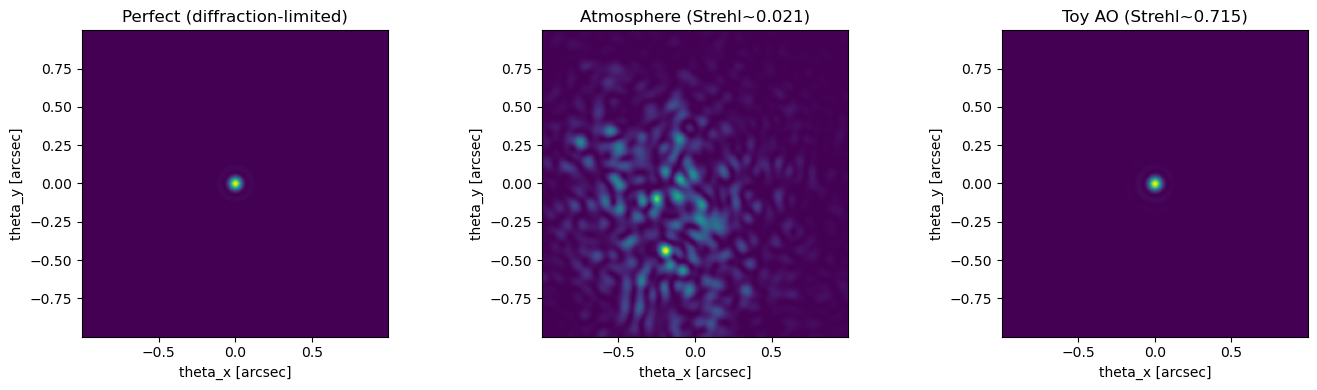

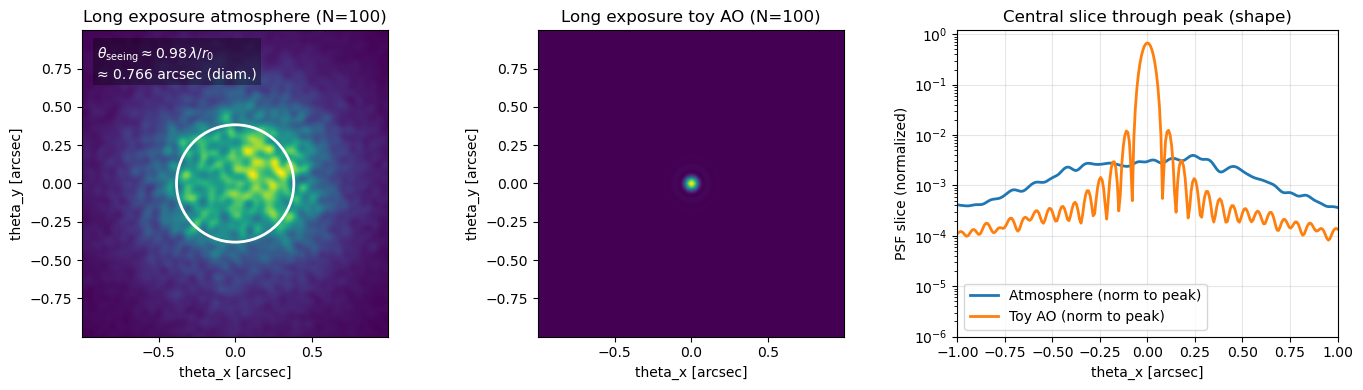


Notes:
- W(x,y) is OPD [m] and is assumed wavelength-independent; phase is phi=(2*pi/lambda)*W.
- actuator_spacing controls how much low-order phase is removed (smaller spacing -> better correction).
- Long exposure averages speckles into a smoother halo.


In [24]:
# HW2a Problem 4 (template cell + toy AO)
# Perfect PSF vs atmosphere vs simple AO (low-pass correction), plus long-exposure halo
# No external helper file.

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Circle


# ----------------------------
# User-controlled parameters
# ----------------------------
D = 6.5                 # telescope diameter [m]
lam =2e-6            # observing wavelength [m]
r0_550nm = 0.1         # Fried parameter [m] at standard visible band
r0  = r0_550nm * (lam/500e-9)**(6./5)              # Fried parameter [m] at obseving wavelength (lam)

n = 256                 # pupil grid size
oversample = 4          # FFT padding factor (2,4,8...)
fov_arcsec = 1.0        # plot +/- this FOV in arcsec
log_display = False      # log10 stretch for display only

# Toy AO parameter (students vary this)
actuator_spacing = 0.20  # [m]  (smaller = more capable DM)
remove_tt = False      # Many telescope have a fast tip-tilt loop that just centers the image peak
                       # It can be pretty effective at improving image quality even with no AO.. try it!

# Long exposure averaging (for atmosphere and AO residual)
N_long = 100              # number of independent realizations to average (e.g., 1, 10, 100)

seed = None
rng = np.random.default_rng(seed)

# ----------------------------
# 1) Pupil-plane coordinate grid + circular aperture
# ----------------------------
L = 2.0 * D
x = np.linspace(-L/2, L/2, n, endpoint=False)
dx = x[1] - x[0]

X, Y = np.meshgrid(x, x, indexing="xy")
R = np.sqrt(X**2 + Y**2)
A = (R <= (D/2)).astype(float)
pupil = (A > 0)

# ----------------------------
# 2) Kolmogorov OPD screen W(x,y) [m]
# ----------------------------
def kolmogorov_opd_screen(n, dx, D, r0, lam_r0, rng, pupil_mask, X, Y, big_factor=4):
    """
    FFT Kolmogorov OPD screen generated on a bigger grid, then cropped.

    big_factor=2 means generate on (2n x 2n), then crop to (n x n).
    This reduces periodic boundary artifacts across the pupil.
    """
    nb = int(big_factor) * n
    if nb < n:
        nb = n

    # BIG grid frequencies
    fx = np.fft.fftfreq(nb, d=dx)
    FX, FY = np.meshgrid(fx, fx, indexing="xy")
    f = np.sqrt(FX**2 + FY**2)
    f[0, 0] = np.inf

    PSD_shape = f**(-11.0/3.0)

    noise = (rng.standard_normal((nb, nb)) + 1j*rng.standard_normal((nb, nb)))
    phase_ft = noise * np.sqrt(PSD_shape)
    phi_big = np.fft.ifft2(phase_ft).real

    # Crop central n x n
    i0 = (nb - n)//2
    j0 = (nb - n)//2
    phi_raw = phi_big[i0:i0+n, j0:j0+n]

    # Remove piston over pupil
    phi_raw = phi_raw - np.mean(phi_raw[pupil_mask])

    # Scale RMS to Kolmogorov aperture phase variance
    sigma_phi_target = np.sqrt(1.03 * (D / r0)**(5.0/3.0))
    sigma_phi_now = np.std(phi_raw[pupil_mask])
    phi = phi_raw * (sigma_phi_target / sigma_phi_now)

    # Convert phase -> OPD [m]
    W = (lam_r0 / (2*np.pi)) * phi
    W = W * pupil_mask.astype(float)
    return W


# ----------------------------
# 3) Simple "toy AO": subtract low-pass (DM-fit) phase set by actuator_spacing
# ----------------------------
def remove_piston_tilt(phi, pupil_mask, X, Y):
    """
    Fit phi ~ a + b*X + c*Y over pupil and subtract (removes piston + tip/tilt).
    """
    x = X[pupil_mask].ravel()
    y = Y[pupil_mask].ravel()
    z = phi[pupil_mask].ravel()
    G = np.column_stack([np.ones_like(x), x, y])
    coeff, *_ = np.linalg.lstsq(G, z, rcond=None)
    a, b, c = coeff
    phi_fit = a + b*X + c*Y
    return phi - phi_fit

def recenter_psf(psf):
    ny, nx = psf.shape
    iy, ix = np.unravel_index(np.argmax(psf), psf.shape)
    cy, cx = ny//2, nx//2
    return np.roll(np.roll(psf, cy - iy, axis=0), cx - ix, axis=1)

def toy_AO_residual(phi_atm, pupil_mask, dx, actuator_spacing, X, Y, gain=1.0, remove_tt=False):
    """
    DM can correct only low spatial frequencies.
    We model that as: phi_corr = gain * GaussianLowPass(phi_atm)
    Then: phi_res = phi_atm - phi_corr   (inside pupil)

    actuator_spacing [m] sets low-pass scale:
      sigma_pix ~ (actuator_spacing/dx)/2 is a reasonable heuristic.

    This is a *toy* model (no WFS noise, no servo lag, etc.).
    """
    sigma_pix = (actuator_spacing / dx) / 2.0

    # Smooth only the pupil content; keep outside pupil at 0
    phi_in = np.zeros_like(phi_atm)
    phi_in[pupil_mask] = phi_atm[pupil_mask]

    phi_low = gaussian_filter(phi_in, sigma=sigma_pix, mode="constant", cval=0.0)
    phi_corr = gain * phi_low

    phi_res = (phi_atm - phi_corr) * pupil_mask.astype(float)

    if remove_tt:
        phi_res = remove_piston_tilt(phi_res, pupil_mask, X, Y) * pupil_mask.astype(float)

    return phi_res

# ----------------------------
# 4) Pupil -> PSF (2D FFT with explicit symmetric padding)
# ----------------------------
def pupil_to_psf_2d(A, phi, dx, lam, oversample=4):
    n = A.shape[0]
    nfft = int(oversample) * n

    U = A * np.exp(1j * phi)

    pad_total = nfft - n
    pad_left = pad_total // 2
    pad_right = pad_total - pad_left
    U_pad = np.pad(U, ((pad_left, pad_right), (pad_left, pad_right)),
                   mode="constant", constant_values=0.0)

    Uf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(U_pad)))
    psf = np.abs(Uf)**2

    f = np.fft.fftshift(np.fft.fftfreq(nfft, d=dx))
    theta = lam * f
    THX, THY = np.meshgrid(theta, theta, indexing="xy")
    return THX, THY, psf

def crop_for_display(psf_img, THX, THY, fov_arcsec):
    thx = THX * 206265.0
    thy = THY * 206265.0
    m = (np.abs(thx) <= fov_arcsec) & (np.abs(thy) <= fov_arcsec)
    ii, jj = np.where(m)
    i0, i1 = ii.min(), ii.max()
    j0, j1 = jj.min(), jj.max()
    ps = psf_img[i0:i1+1, j0:j1+1]
    extent = [thx[i0, j0], thx[i0, j1], thy[i0, j0], thy[i1, j0]]
    return ps, extent

# ----------------------------
# 5) Single short-exposure realization: perfect vs atmosphere vs toy AO
# ----------------------------
# Diffraction-limited reference
THX_dl, THY_dl, psf_dl = pupil_to_psf_2d(A, 0.0*A, dx, lam, oversample=oversample)
Imax_dl = np.max(psf_dl)

# One atmosphere screen
W = kolmogorov_opd_screen(n, dx, D, r0=r0, lam_r0=lam, rng=rng, pupil_mask=pupil, X=X, Y=Y, big_factor=4)
phi_atm = (2*np.pi/lam) * W

# Toy AO residual phase
phi_res = toy_AO_residual(phi_atm, pupil, dx, actuator_spacing, X, Y, gain=1.0, remove_tt=False)

# PSFs
THX, THY, psf_atm = pupil_to_psf_2d(A, phi_atm, dx, lam, oversample=oversample)
THX, THY, psf_ao  = pupil_to_psf_2d(A, phi_res, dx, lam, oversample=oversample)

# Strehl via peak ratio (linear PSFs!)
strehl_atm = np.max(psf_atm) / Imax_dl
strehl_ao  = np.max(psf_ao)  / Imax_dl

# RMS phase and Marechal comparison
sigma_phi_atm = np.std(phi_atm[pupil])
sigma_phi_res = np.std(phi_res[pupil])
marechal_atm = np.exp(-(sigma_phi_atm**2))
marechal_ao  = np.exp(-(sigma_phi_res**2))

print("Short exposure (one realization):")
print(f"  D={D:.2f} m, lambda={lam*1e9:.0f} nm, r0={r0*100:.1f} cm")
print(f"  actuator_spacing = {actuator_spacing*100:.1f} cm")
print(f"  Atmosphere: Actual Strehl={strehl_atm:.4f}  sigma_phi={sigma_phi_atm:.3f} rad  exp(-sigma^2)={marechal_atm:.4f}")
print(f"  Toy AO:     Actual Strehl={strehl_ao:.4f}  sigma_phi={sigma_phi_res:.3f} rad  exp(-sigma^2)={marechal_ao:.4f}")

# Plot the three PSFs (normalized by DL peak)
psf_dl_norm  = psf_dl / Imax_dl
psf_atm_norm = psf_atm / Imax_dl
psf_ao_norm  = psf_ao / Imax_dl



fig, ax = plt.subplots(1, 3, figsize=(14, 4))

for axi, psf_img, title in [
    (ax[0], psf_dl_norm,  "Perfect (diffraction-limited)"),
    (ax[1], psf_atm_norm, f"Atmosphere (Strehl~{strehl_atm:.3f})"),
    (ax[2], psf_ao_norm,  f"Toy AO (Strehl~{strehl_ao:.3f})")
]:
    ps, extent = crop_for_display(psf_img, THX_dl, THY_dl, fov_arcsec)
    if log_display:
        img = np.log10(ps + 1e-20)
    else:
        img = ps
    axi.imshow(img, origin="lower", extent=extent)
    axi.set_title(title)
    axi.set_xlabel("theta_x [arcsec]")
    axi.set_ylabel("theta_y [arcsec]")

plt.tight_layout()
plt.show()

# ----------------------------
# 6) Long exposure: average N_long realizations (atmosphere vs toy AO)
#     + add a 1D slice through the peak (overlay AO vs no-AO)
# ----------------------------
psf_sum_atm = 0.0
psf_sum_ao  = 0.0

for i in range(N_long):
    W = kolmogorov_opd_screen(n, dx, D, r0=r0, lam_r0=lam, rng=rng, pupil_mask=pupil, X=X, Y=Y,big_factor=4)
    phi_atm = (2*np.pi/lam) * W
    phi_res = toy_AO_residual(phi_atm, pupil, dx, actuator_spacing, X, Y, gain=1.0, remove_tt=remove_tt)

    _, _, psf_atm_i = pupil_to_psf_2d(A, phi_atm, dx, lam, oversample=oversample)
    _, _, psf_ao_i  = pupil_to_psf_2d(A, phi_res, dx, lam, oversample=oversample)

    
    if remove_tt == True:
        psf_atm_i = recenter_psf(psf_atm_i)
        psf_ao_i  = recenter_psf(psf_ao_i)
        
    psf_sum_atm += psf_atm_i
    psf_sum_ao  += psf_ao_i

psf_long_atm = (psf_sum_atm / N_long) / Imax_dl
psf_long_ao  = (psf_sum_ao  / N_long) / Imax_dl

# ---- NEW: 3 panels (2 images + 1 slice) ----
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
theta_seeing_rad = 0.98 * lam / r0
theta_seeing_arcsec = theta_seeing_rad * 206265.0   # this is an ANGULAR FWHM-ish scale
# Panels 0 and 1: the images (same as before)
for axi, psf_img, title in [
    (ax[0], psf_long_atm, f"Long exposure atmosphere (N={N_long})"),
    (ax[1], psf_long_ao,  f"Long exposure toy AO (N={N_long})")
]:
    ps, extent = crop_for_display(psf_img, THX_dl, THY_dl, fov_arcsec)
    if log_display:
        img = np.log10(ps + 1e-20)
    else:
        img = ps
    axi.imshow(img, origin="lower", extent=extent)
    

    # ... inside the long-exposure plotting loop, after axi.imshow(...)
    if "atmosphere" in title:  # only annotate the atmosphere long exposure panel
        # Circle with diameter = theta_seeing_arcsec => radius = half that
        circ = Circle((0.0, 0.0), radius=0.5*theta_seeing_arcsec,
                      fill=False, lw=2, edgecolor="white")
        axi.add_patch(circ)
        axi.text(0.05, 0.95,
                 r"$\theta_{\rm seeing}\approx0.98\,\lambda/r_0$"
                 f"\n≈ {theta_seeing_arcsec:.3f} arcsec (diam.)",
                 transform=axi.transAxes, va="top", ha="left",
                 color="white",
                 bbox=dict(facecolor="black", alpha=0.35, edgecolor="none", pad=3))


    axi.set_title(title)
    axi.set_xlabel("theta_x [arcsec]")
    axi.set_ylabel("theta_y [arcsec]")

# ---- NEW: Panel 2 = 1D slice through peak (horizontal cut through center) ----
# Angle axis in arcsec (1D) from THX_dl row through center
mid = THX_dl.shape[0] // 2
theta_arcsec_1d = THX_dl[mid, :] * 206265.0

# Central horizontal slices through the long-exposure PSFs
slice_atm = psf_long_atm[mid, :]
slice_ao  = psf_long_ao[mid, :]

# (Optional) normalize slices to their own peaks to compare shapes,
# OR comment these out to compare absolute peak ratios.
slice_atm_plot = slice_atm #/ np.max(slice_atm)
slice_ao_plot  = slice_ao  #/ np.max(slice_ao)

ax[2].plot(theta_arcsec_1d, slice_atm_plot, lw=2, label="Atmosphere (norm to peak)")
ax[2].plot(theta_arcsec_1d, slice_ao_plot,  lw=2, label="Toy AO (norm to peak)")

# If you want to emphasize halos, log-y is very helpful:
ax[2].set_yscale("log")

ax[2].set_xlim(-fov_arcsec, fov_arcsec)
ax[2].set_ylim(1e-6, 1.2)   # adjust floor depending on how deep you want to see
ax[2].grid(True, alpha=0.3)
ax[2].set_title("Central slice through peak (shape)")
ax[2].set_xlabel("theta_x [arcsec]")
ax[2].set_ylabel("PSF slice (normalized)")
ax[2].legend()

plt.tight_layout()
plt.show()


print("\nNotes:")
print("- W(x,y) is OPD [m] and is assumed wavelength-independent; phase is phi=(2*pi/lambda)*W.")
print("- actuator_spacing controls how much low-order phase is removed (smaller spacing -> better correction).")
print("- Long exposure averages speckles into a smoother halo.")
